# Biodiversity in National Park

For this project, we will interpret data from the National Parks Service about endangered species in different parks.

## Goals

Applying data analysis methods, including :
- data cleaning
- exploratory data analysis
- summary statistics and data visualization
- communicating insights through a slide deck

## Data

We dispose of two datasets in the csv format, `observations.csv` and `species_info.csv` within the `data` folder.

`species_info.csv`:
- category : class of animal
- scientific_name : the scientific name of each species
- common_name : the common name of each species
- conservation_status : each species' current conservation status

`observations.csv`:
- scientific_name : the scientific name of each species
- park_name : the park where species are observed
- observations : the number of times each species was observed at park

## Analysis

The main questions to answer :
1. What is the frequency of each category, and across the different statuses ?
2. What is the distribution of `conservation_status` for animals ?
3. What are the species that are more likely to be endangered ?
4. What are the most observed species, and across each park ?
<hr>

##### Let's get to work !!!

### I- Exploring and cleaning data

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# loading the first dataset
info = pd.read_csv('data/species_info.csv')

##### Exploring `species_info`

In [22]:
# inspecting the dataset
print(info.head(5))
print('-------------------------------------------------------------------------------------')
# exploring columns and datatypes
print(info.columns)
print('-------------------------------------------------------------------------------------')
print(info.dtypes)
print('-------------------------------------------------------------------------------------')
print(info.info())
print('-------------------------------------------------------------------------------------')
print(info.describe(include='all'))
print('-------------------------------------------------------------------------------------')

  category                scientific_name  \
0   Mammal  Clethrionomys gapperi gapperi   
1   Mammal                      Bos bison   
2   Mammal                     Bos taurus   
3   Mammal                     Ovis aries   
4   Mammal                 Cervus elaphus   

                                        common_names conservation_status  
0                           Gapper's Red-Backed Vole                 NaN  
1                              American Bison, Bison                 NaN  
2  Aurochs, Aurochs, Domestic Cattle (Feral), Dom...                 NaN  
3  Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)                 NaN  
4                                      Wapiti Or Elk                 NaN  
-------------------------------------------------------------------------------------
Index(['category', 'scientific_name', 'common_names', 'conservation_status'], dtype='object')
-------------------------------------------------------------------------------------
category     

Starting with the dataset inspection, it seems like all the columns are indeed nominal. both the `category` and `conservation_status` are categorical and have a few number of distinct values which we are going to discover, the `scientific_name` is categorical but unique values are numerous since each species has its own scientific name, but `common_names` doesn't represent categories, it represents a list of common names separated by commas, so it'd be better to change this column's type to `string` rather than `object`.

In [23]:
# changin column type
info['common_names'] = info['common_names'].astype('string')

# eliminating rows with duplicate values for scientific_name
info = info.drop_duplicates(subset=['scientific_name'])

# dropping the common_names column
info = info[['scientific_name', 'category', 'conservation_status']]

In [24]:
print(info.info())
print('-------------------------------------------------------------------------------------')
print(info.describe(include='all'))
print('-------------------------------------------------------------------------------------')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5541 entries, 0 to 5823
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   scientific_name      5541 non-null   object
 1   category             5541 non-null   object
 2   conservation_status  178 non-null    object
dtypes: object(3)
memory usage: 173.2+ KB
None
-------------------------------------------------------------------------------------
                      scientific_name        category conservation_status
count                            5541            5541                 178
unique                           5541               7                   4
top     Clethrionomys gapperi gapperi  Vascular Plant  Species of Concern
freq                                1            4262                 151
-------------------------------------------------------------------------------------


Moving on, we see that the only column that has null values is actually `conservation_status`, we'll investigate later on the reason of this missingess. Now let's examine the different categories we have for our `category` and `conservation_status` columns.

In [25]:
# examining the distinct categories
print('The seven categories of species we have are :')
for category in info.category.unique():
    print('\t- ', category)

conservation_statuses = info.conservation_status.dropna().unique()
print('The four conservation statuses are :')
for status in info.conservation_status.dropna().unique():
    print('\t- ', status)

The seven categories of species we have are :
	-  Mammal
	-  Bird
	-  Reptile
	-  Amphibian
	-  Fish
	-  Vascular Plant
	-  Nonvascular Plant
The four conservation statuses are :
	-  Species of Concern
	-  Endangered
	-  Threatened
	-  In Recovery


Let's try to get a better sense of the data and the proportion of each category through visualizations.

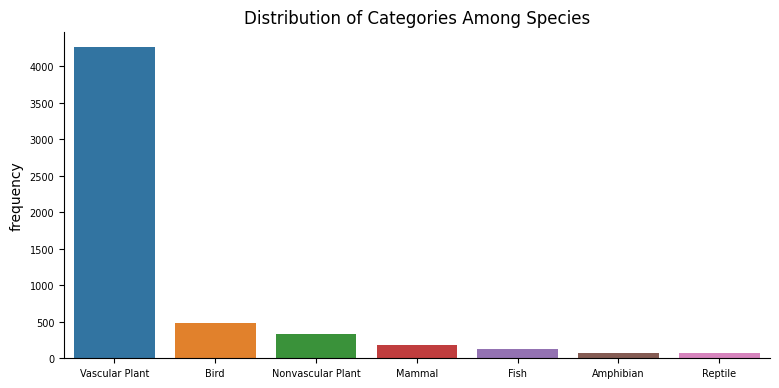

In [26]:
# bar chart of categories
sns.catplot(
    data=info,
    x='category', kind='count', order=info.category.value_counts().index,
    height=4, aspect=2
)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.title('Distribution of Categories Among Species')
plt.xlabel('')
plt.ylabel('frequency')
plt.show()

The 'Vascular Plant' category is dominant.<br>
Next, let's try to get the distribution of categories with missing conservation status.

In [27]:
# counting null values on conservation status for each category
df = info.conservation_status.isna().groupby(info.category).sum().sort_values(ascending=False).reset_index().rename(columns={'conservation_status': 'missing_count'})

<Figure size 1000x500 with 0 Axes>

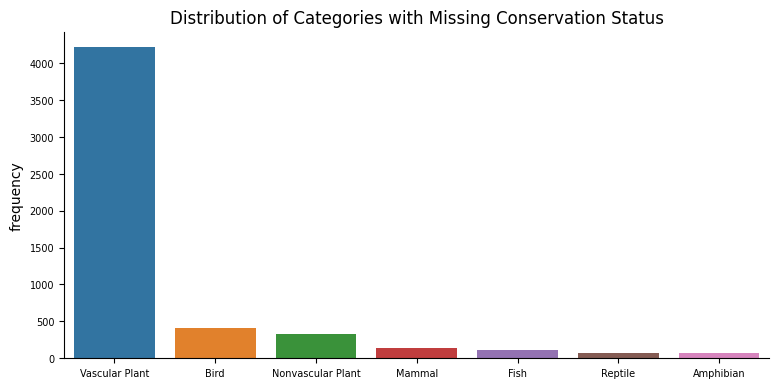

In [28]:
# bar chart
plt.figure(figsize=(10,5))
sns.catplot(
    data=df,
    x='category', y='missing_count', kind='bar',
    height=4, aspect=2
)
plt.title('Distribution of Categories with Missing Conservation Status')
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.ylabel('frequency')
plt.xlabel('')
plt.show()

We notice that the distribution of categories with missing conservation status tends to be identical to the general distribution of categories, meaning that this could be a MCAR (missing completely at random) data, since that for all groups, data is equally likely to be missing, meaning that maybe we need to get rid of it, because we can't predict any values to be there.

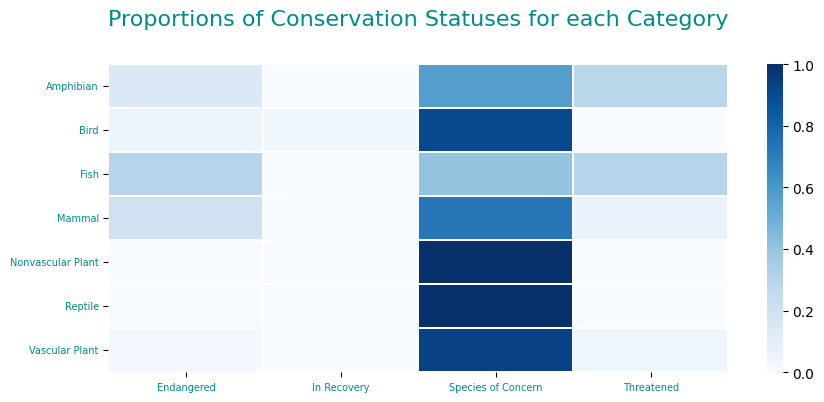

In [29]:
# eliminating rows with missing values for conservation_status
info_ = info.dropna(subset='conservation_status')

# 1: getting the count of species for each category
category_count = info_[['scientific_name', 'category']].groupby('category').count().reset_index()

# 2: getting the count of species with each conservation_status for each category
category_status_count = info_[['scientific_name', 'category', 'conservation_status']].groupby(by=['category', 'conservation_status']).count().reset_index().merge(category_count, how='inner', on='category')

# 3: dividing the count of the second dataframe by those of the first for getting the proportion of each conservation_status from each category
category_status_count['proportion'] = (category_status_count.scientific_name_x / category_status_count.scientific_name_y)

# 4: preparing the dataframe for the heatmap
category_status_count = category_status_count[['category', 'conservation_status', 'proportion']].pivot_table(
    index='category',
    columns='conservation_status',
    values='proportion'
).fillna(0)

# 5: creating the heatmap
fig = plt.figure(figsize=(10,4))

sns.heatmap(
    data=category_status_count,
    linewidths=0.1, linecolor='white',
    cmap='Blues'
)

plt.title('Proportions of Conservation Statuses for each Category', fontsize=16, y=1.1, color='darkcyan')
plt.xlabel('')
plt.ylabel('')
plt.xticks(fontsize=7, color='darkcyan')
plt.yticks(fontsize=7, color='darkcyan')

plt.show()

From the graph above, if we take a look at the endangered status, which is what we are mostly interested in, we see that fishes and mammals have the highest proportions. Meanwhile, plants, reptiles and birds are mostly species of concern.<br>
These results would be so much more accurate if we didn't have that much rate of missing values for the status variable, but with the data we have in our hands, these insights make a good investigation for the endangered species, and maybe we can get more while exploring the second dataset. 

##### Exploring `species_info`

In [30]:
# loading the second dataset
obs = pd.read_csv('data/observations.csv')

# inspecting the dataset
print(obs.head(5))
print('-------------------------------------------------------------------------------------')
# exploring columns and datatypes
print(obs.columns)
print('-------------------------------------------------------------------------------------')
print(obs.dtypes)
print('-------------------------------------------------------------------------------------')
print(obs.info())
print('-------------------------------------------------------------------------------------')
print(obs.describe(include='all'))
print('-------------------------------------------------------------------------------------')

            scientific_name                            park_name  observations
0        Vicia benghalensis  Great Smoky Mountains National Park            68
1            Neovison vison  Great Smoky Mountains National Park            77
2         Prunus subcordata               Yosemite National Park           138
3      Abutilon theophrasti                  Bryce National Park            84
4  Githopsis specularioides  Great Smoky Mountains National Park            85
-------------------------------------------------------------------------------------
Index(['scientific_name', 'park_name', 'observations'], dtype='object')
-------------------------------------------------------------------------------------
scientific_name    object
park_name          object
observations        int64
dtype: object
-------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23296 entries, 0 to 23295
Data columns (total 3 column

One thing is unusual here, notice how there are 4 occurences of the scientific_name Myotis Lucifugus, eventhough there are only 4 parks, let's zoom in to this part of the dataframe. 

In [31]:
# inspecting the scientific name Myotis lucifugus
print(obs.loc[obs.scientific_name == 'Myotis lucifugus'])

        scientific_name                            park_name  observations
1603   Myotis lucifugus  Great Smoky Mountains National Park            57
7094   Myotis lucifugus            Yellowstone National Park           239
8308   Myotis lucifugus  Great Smoky Mountains National Park            59
9318   Myotis lucifugus                  Bryce National Park           103
9738   Myotis lucifugus               Yosemite National Park           124
10759  Myotis lucifugus                  Bryce National Park           108
11395  Myotis lucifugus  Great Smoky Mountains National Park            58
12562  Myotis lucifugus            Yellowstone National Park           233
13611  Myotis lucifugus               Yosemite National Park           134
15865  Myotis lucifugus                  Bryce National Park            87
16038  Myotis lucifugus               Yosemite National Park           138
16384  Myotis lucifugus            Yellowstone National Park           207


It's very clear now, we have repeated observations, the best and most intuitive way to deal with this is to add up observations for the same park for each species, so we get exactly 4 occurences for each species, exactly 1 occurence for each park.

In [32]:
obs = obs.groupby(by=['scientific_name', 'park_name']).sum('observations').reset_index()

In [33]:
print(obs.head())
print('-------------------------------------------------------------------------------------')
print(obs.describe(include='all'))
print('-------------------------------------------------------------------------------------')

  scientific_name                            park_name  observations
0   Abies bifolia                  Bryce National Park           109
1   Abies bifolia  Great Smoky Mountains National Park            72
2   Abies bifolia            Yellowstone National Park           215
3   Abies bifolia               Yosemite National Park           136
4  Abies concolor                  Bryce National Park            83
-------------------------------------------------------------------------------------
       scientific_name            park_name  observations
count            22164                22164  22164.000000
unique            5541                    4           NaN
top      Abies bifolia  Bryce National Park           NaN
freq                 4                 5541           NaN
mean               NaN                  NaN    149.555089
std                NaN                  NaN     81.421299
min                NaN                  NaN      9.000000
25%                NaN              

`scientific_name` and `park_name` are both nominal variables while `observation` is a discrete quantitative variable. Notice the existence of four categories of parks, and 5541 distinct species, the same number of species described in the `species_info` dataset.

In [34]:
parks = obs.park_name.unique()

print('The available parks where we observed the different species :')
for park in parks:
    print(f'\t- {park}')

The available parks where we observed the different species :
	- Bryce National Park
	- Great Smoky Mountains National Park
	- Yellowstone National Park
	- Yosemite National Park


From inspecting the data, it appears that for each species, we associate its observation with each of the four parks.

In [35]:
def most_least_viewer(obs, top):

    # most and least observed species
    obs_species = obs.groupby(by='scientific_name').sum('observations').reset_index()

    # adding the category column for each species
    obs_species = pd.merge(obs_species, info, how='inner', left_on = 'scientific_name', right_on = 'scientific_name')[['scientific_name', 'category', 'observations']]

    print(f'The top {top} most observed species are:\n-------------------------------------')
    print(obs_species.sort_values(by='observations', ascending=False)[['scientific_name', 'category', 'observations']].head(top))
    print(f'\nThe top {top} least observed species are:\n--------------------------------------')
    print(obs_species.sort_values(by='observations', ascending=True)[['scientific_name', 'category', 'observations']].head(top))

most_least_viewer(obs, 10)

The top 10 most observed species are:
-------------------------------------
            scientific_name        category  observations
4993  Streptopelia decaocto            Bird          1785
2452         Holcus lanatus  Vascular Plant          1780
1103      Castor canadensis          Mammal          1725
2555   Hypochaeris radicata  Vascular Plant          1720
4179          Puma concolor          Mammal          1711
4109          Procyon lotor          Mammal          1692
1359          Columba livia            Bird          1653
3322       Myotis lucifugus          Mammal          1547
583       Bidens tripartita  Vascular Plant          1296
3494        Oxalis dillenii  Vascular Plant          1276

The top 10 least observed species are:
--------------------------------------
                   scientific_name   category  observations
2323                Grus americana       Bird           131
805                    Canis rufus     Mammal           137
5356           Vermivora ba

Let's get deeper and look at the top 3 most and least observed species for each park.

In [36]:
parks = ['Bryce National Park', 'Great Smoky Mountains National Park', 'Yellowstone National Park', 'Yosemite National Park']

for park in parks:
    dataset = obs.loc[obs.park_name == park]
    print(f'Viewer for {park}\n')
    most_least_viewer(dataset, 3)
    print('\n\n\n')

Viewer for Bryce National Park

The top 3 most observed species are:
-------------------------------------
     scientific_name        category  observations
1359   Columba livia            Bird           339
4179   Puma concolor          Mammal           311
533     Avena sativa  Vascular Plant           303

The top 3 least observed species are:
--------------------------------------
              scientific_name        category  observations
1415          Corydalis aurea  Vascular Plant             9
5356      Vermivora bachmanii            Bird            20
3492  Ovis canadensis sierrae          Mammal            22




Viewer for Great Smoky Mountains National Park

The top 3 most observed species are:
-------------------------------------
            scientific_name category  observations
4993  Streptopelia decaocto     Bird           256
4109          Procyon lotor   Mammal           247
1103      Castor canadensis   Mammal           243

The top 3 least observed species are:
-

It appears that, in one hand, vascular plants, mammals and birds appeart to be at the top 3 of the most observed species for every park. On the other hand, we also find mammals in addition to fishes and amphibians at the least observed species.<br>
It's really hard to make conclusions because of the extremely dominant missing values, and because of the disproportion of the categories for our species. This is the furthest we're gonna go in our investigation of this dataset.<br>
Lastly, in order to protect species from extinction, we need to look at the areas where species are collected for each park, there might be some kinf of activities that are threatening these specific animals.<br>
I suggest that in order to provide more accurate insights for the sake of protecting endangered species, more care and research need to be done in the data collection part, in order to provide more accurate information about the status, for us to be able to analyze each category independantly, and seeing if some category being endangered cause other categories to be endangered as well.